In [1]:
# ! pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# ! pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

 # please re-start kernel if these packages are installed for the first time

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
from phantasy import caget,fetch_data

In [3]:
import objFuncs
from objFuncs.util import plot_obj_history
from pyBO import pyBO

objFuncs version: 1.0.2. updated on 2023-12-19
pyBO version: 1.0.0. updated on 2023-12-14


# check objFuncs machineIO, source and beam  

In [4]:
objFuncs._global_machineIO._test = False
objFuncs._global_machineIO._fetch_data_time_span = 1
objFuncs._global_machineIO._ensure_set_timewait_after_ramp : 0.25
objFuncs._global_machineIO.view()

   _test : False
   _ensure_set_timeout : 30
   _ensure_set_timewait_after_ramp : 0.25
   _fetch_data_time_span : 1
   _return_obj_var : False
   _check_chopper_blocking : True
   _n_popup_ramping_not_OK : 0
   _verbose : False


In [5]:
SCS = caget("ACS_DIAG:DEST:ACTIVE_ION_SOURCE")
ion = caget("FE_ISRC"+str(SCS)+":BEAM:ELMT_BOOK")
Q = caget("FE_ISRC"+str(SCS)+":BEAM:Q_BOOK")
A = caget("FE_ISRC"+str(SCS)+":BEAM:A_BOOK")
# AQ = caget("FE_ISRC2:BEAM:MOVRQ_BOOK")
AQ = A/Q
ion = str(A)+ion+str(Q)
print('SCS'+str(SCS), ion, 'A/Q=',AQ)

SCS2 238U35 A/Q= 6.8


In [6]:
now0 = datetime.datetime.now()
now0str = now0.strftime('%Y%m%d_%H%M')
fname = now0str+'['+ion+'][LSQ][U-LEBT]FC814_2ndCup'
fname

'20231221_1534[238U35][LSQ][U-LEBT]FC814_2ndCup'

# preprare objective

In [7]:
decision_CSETs = [
                  'FE_LEBT:PSC2_D0773:I_CSET',
                  'FE_LEBT:PSC1_D0773:I_CSET',
                  'FE_LEBT:PSC2_D0790:I_CSET',
                  'FE_LEBT:PSC1_D0790:I_CSET',
                  ]
frac = 0.8
decision_min = [-frac*AQ]*len(decision_CSETs)
decision_max = [ frac*AQ]*len(decision_CSETs)

list(zip(decision_min, decision_max))  # bounds

[(-5.44, 5.44), (-5.44, 5.44), (-5.44, 5.44), (-5.44, 5.44)]

In [8]:
fetch_data(decision_CSETs,0.01)[0]

array([0., 0., 0., 0.])

In [9]:
res = objFuncs.residuals.residualObj(
    decision_CSETs=decision_CSETs,
    decision_min = decision_min,
    decision_max = decision_max,
    objective_goal   = {'FE_LEBT:FC_D0814:PKAVG_RD': 28},
    objective_weight = {'FE_LEBT:FC_D0814:PKAVG_RD': 1},
    objective_norm   = {'FE_LEBT:FC_D0814:PKAVG_RD': 10},
)

======== class info ========
init_time: 2023-12-21 15:34:54.491680
class_hierarchy: [
    residualObj, objFuncBase]
machineIO: <objFuncs.construct_machineIO.construct_machineIO object at 0x7fef602d2a50>
decision_CSETs: [
    FE_LEBT:PSC2_D0773:I_CSET, FE_LEBT:PSC1_D0773:I_CSET, FE_LEBT:PSC2_D0790:I_CSET
    FE_LEBT:PSC1_D0790:I_CSET]
decision_min: [-5.44 -5.44 -5.44 -5.44]
decision_max: [5.44 5.44 5.44 5.44]
decision_bounds: [[-5.44  5.44]
 [-5.44  5.44]
 [-5.44  5.44]
 [-5.44  5.44]]
decision_RDs: [
    FE_LEBT:PSC2_D0773:I_RD, FE_LEBT:PSC1_D0773:I_RD, FE_LEBT:PSC2_D0790:I_RD
    FE_LEBT:PSC1_D0790:I_RD]
decision_tols: [0.2 0.2 0.2 0.2]
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: 
logging_fname: None
x0: [0. 0. 0. 0.]
objective_goal: {'FE_LEBT:FC_D0814:PKAVG_RD': 28.0}
objective_norm: {'FE_LEBT:FC_D0814:PKAVG_RD': 10}
objective_weight: {'FE_LEBT:FC_D0814:PKAVG_RD': 1}
objective_RDs: [
    FE_LEBT:FC_D0814:PKAVG_RD]



 # Prepare plot callbacks

In [10]:
# define what to plot
plot_CSETs = plot_obj_history(
                res.history['decision_CSETs'],
                title = 'decision_CSETs',
                inline = True,
                )
plot_RDs = plot_obj_history(
                res.history['objective_RDs'],
                title = 'objective_RDs',
                inline = True,
                )
plot_objs = plot_obj_history(
            res.history['objectives'],
            title = 'objectives',
            inline = True,
            )
callbacks = [plot_CSETs,plot_RDs,plot_objs]

# Run LSQ

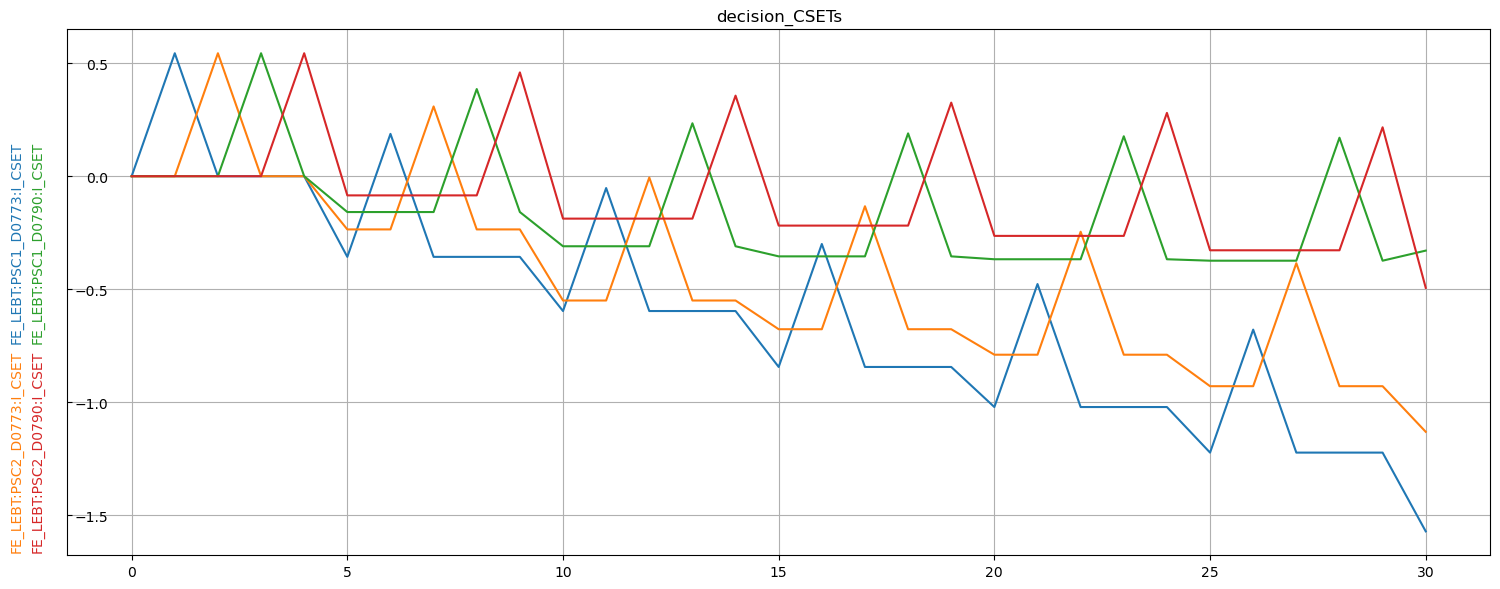

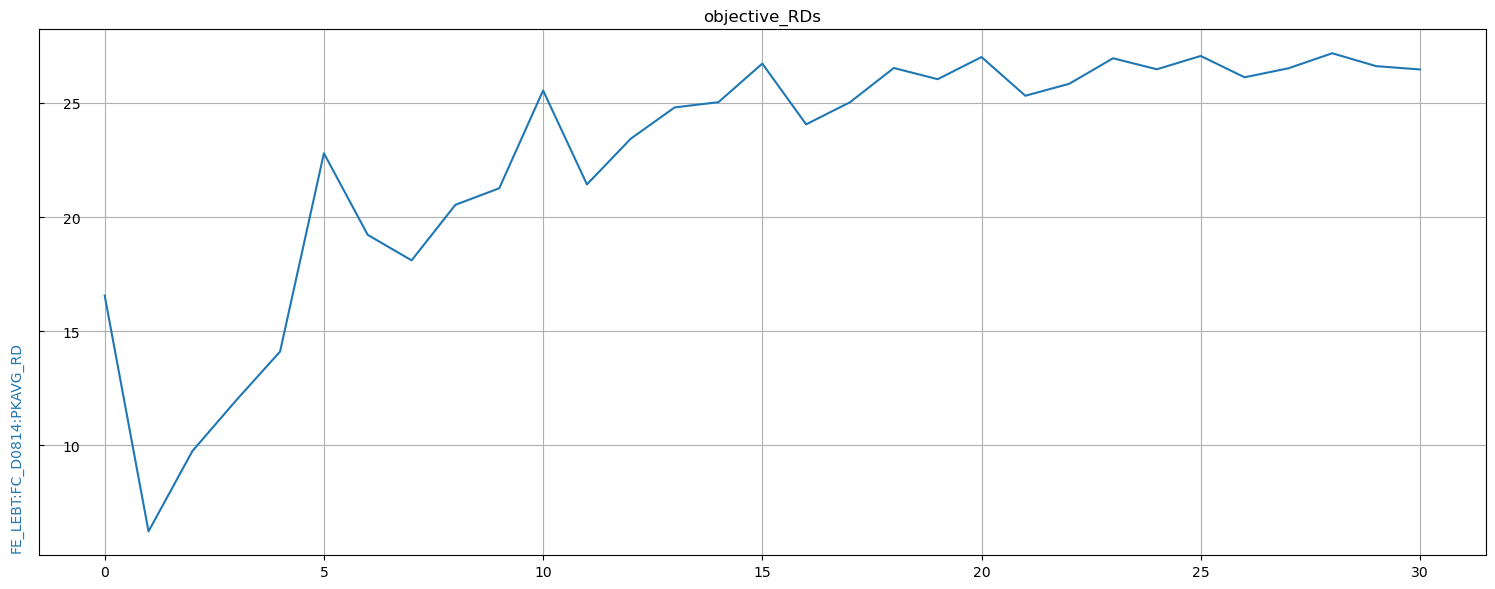

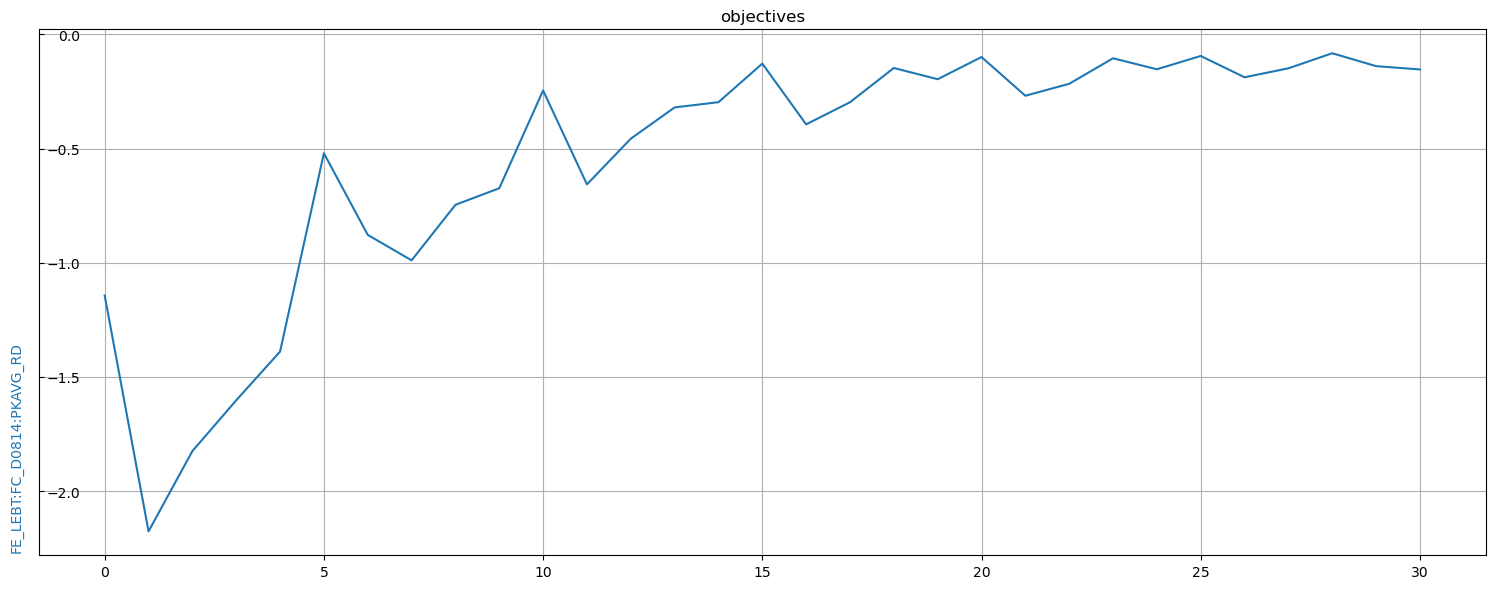

In [11]:
for i in range(6):
    result = res.lsq_linear(jac_use3points=False,callbacks=callbacks)
for f in callbacks:
    f.close()

In [12]:
now1 = datetime.datetime.now()
now1str = now1.strftime('%Y%m%d_%H%M')
time_delta = now1 - now0
print("time took:",str(time_delta.total_seconds()/60)[:4],'min')

time took: 2.54 min


In [13]:
res.write_log(fname='./log/'+fname)

only .pkl file extension is accepted. saving to: ./log/20231221_1534[238U35][LSQ][U-LEBT]FC814_2ndCup.pkl


In [14]:
fetch_data(decision_CSETs,0.01)[0]

array([-1.57090201, -1.1305078 , -0.32899174, -0.49379669])